# Project 2: Time Series Analysis

In [23]:
# Some important libraries to use in time sereies analysis
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
import statsmodels as statsmodels
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
from pandasdmx import Request
import pandas as pd
import os

# Setting fixed figure size
plt.rcParams['figure.figsize'] = [10, 7.5]
plt.rcParams.update({'font.size': 18})


#### Importing Lake Huron Data and Plotting it

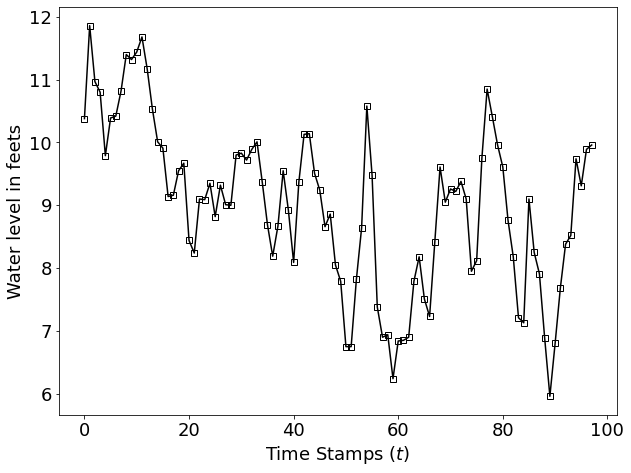

In [3]:
# Obtaining path to data and getting the data
filepath = os.getcwd()
datapath = filepath +"/Data/lakedata.xlsx"
figurepath = filepath+"/Figures"
df = pd.read_excel(datapath)

#plotting data as numpy arrays
data = df.iloc[:,0].to_numpy()
dataTime = np.arange(0,data.shape[0])
plt.figure()
plt.plot(dataTime, data,"k", marker='s', markerfacecolor='none')
plt.xlabel("Time Stamps $(t)$")
plt.ylabel("Water level in feets")

#save figure
plt.savefig(figurepath+"/lakedata.pdf", format="pdf", bbox_inches="tight")
plt.show()


#### Linear regression with Lake Huron Data for $0\leq t \leq 96$

In [162]:
V = np.stack([np.ones(dataTime.shape).T, dataTime.T, (dataTime.T)**2], axis =0).T
VFit = V[0:-10,:]
dataFit = data[0:-10]
a = np.linalg.pinv(VFit.T@VFit)@VFit.T@dataFit.T
a


array([ 1.13054601e+01, -9.78748127e-02,  8.01855335e-04])

#### Plot the polynomial fit

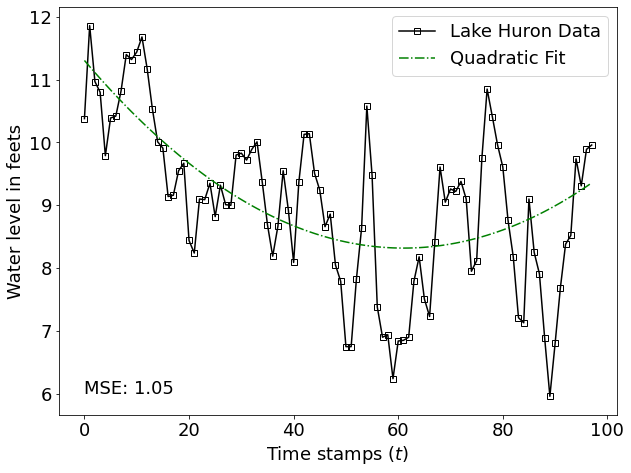

In [168]:
#plotting data as numpy arrays
xPreds = a @ V.T
MSE_Quad =((data - xPreds)**2).mean()
plt.figure()
plt.plot(dataTime, data,  "k", marker='s', markerfacecolor='none')
plt.plot(dataTime, xPreds, 'g-.')
plt.xlabel("Time stamps $(t)$")
plt.ylabel("Water level in feets")
plt.legend(["Lake Huron Data", "Quadratic Fit"])
plt.text(0, 6, "MSE: {:.2f}".format(MSE_Quad))
#save figure
plt.savefig(figurepath+"/lakefit.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [6]:
#predicting water level in 1972
m97 = a@[[1],[97],[97**2]]
print("prediction:",m97[0], " \nactual value:" ,data[-1])

# Error
error =  np.abs(m97 - data[-1])
print("error",error[0])

prediction: 9.3562600875638  
actual value: 9.96
error 0.6037399124362004


#### Residual Plot

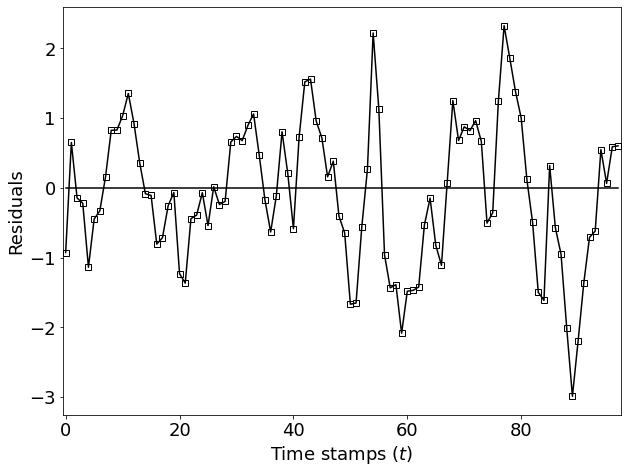

In [7]:
resds = data- xPreds
plt.figure()
plt.plot(dataTime, resds,  "k", marker='s', markerfacecolor='none')
plt.plot(dataTime, np.zeros(dataTime.shape), "k")
plt.xlabel("Time stamps $(t)$")
plt.ylabel("Residuals")
plt.xlim([dataTime[0]-0.5, dataTime[-1]+0.5])
#save figure
plt.savefig(figurepath+"/lakefitres.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Using Statsmodels to get autocovariance and plot them

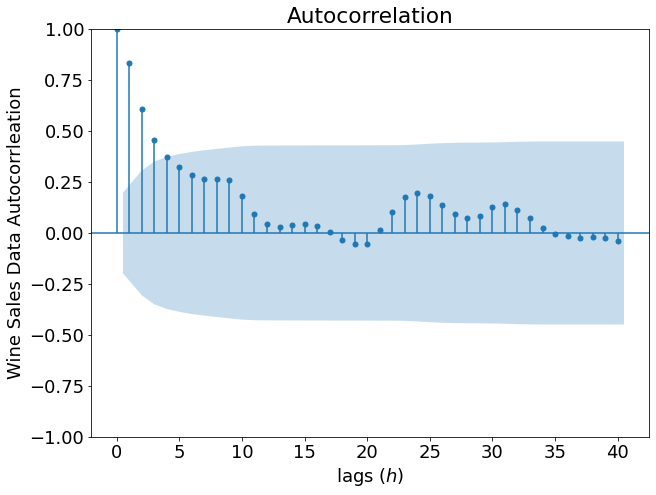

In [174]:
datapathwine = filepath +"/Data/winedata.xlsx"
df = pd.read_excel(datapath)

#plotting data as numpy arrays
winedata = df.iloc[:,0].to_numpy()
winedataTime = np.arange(0,data.shape[0])
plot_acf(winedata, lags =40)
plt.xlabel("lags $(h)$")
plt.ylabel("Wine Sales Data Autocorrleation")

#save figure
plt.savefig(figurepath+"/wineautocov.pdf", format="pdf", bbox_inches="tight")
plt.show()



# Stationary Time Series

### Dickey-Fuller Test for Stanionarity 
As the Test statistic is less than the critican values i.e $-3.8976 < \text{min}[-3.50038, -2.892152, -2.583100]$ , the Wine Sales data is stationary.

In [182]:
#Checking if the data is stationary
result = adfuller(winedata)
# Print test statistic
print(result)

(-3.8976683843687763, 0.0020520736790759007, 1, 96, {'1%': -3.5003788874873405, '5%': -2.8921519665075235, '10%': -2.5830997960069446}, 179.33694888946826)


### Making TS stationary using method of differences
Lets have a look at a non-stationary time series data. Data is about passanger outbound flights at Melbourne Airport from 1985 to 2022. Data Sournce is __[here](https://www.bitre.gov.au/publications/ongoing/airport_traffic_data)__.

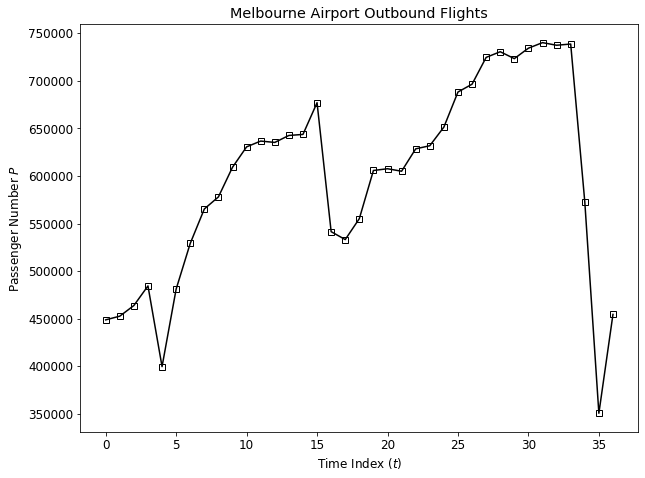

In [219]:
series = pd.read_csv(filepath+'/Data/passengerdata.csv', header=0, index_col=0)
X = series.values
X = np.asarray(X,dtype = float).squeeze()
plt.rcParams.update({'font.size': 12})

plt.plot( X,  "k", marker='s', markerfacecolor='none')
plt.title('Melbourne Airport Outbound Flights')
plt.ylabel("Passenger Number $P$")
plt.xlabel("Time Index $(t)$")
#save figure
plt.savefig(figurepath+"/MelbAirport.pdf", format="pdf", bbox_inches="tight")
plt.show()


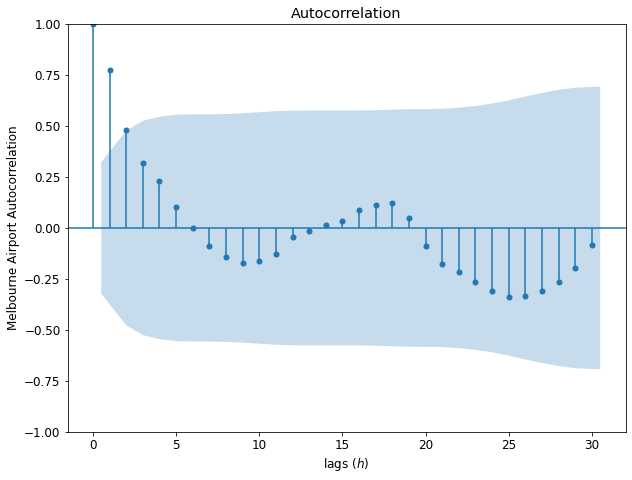

In [223]:
#plot ACVF
plot_acf(X, lags =30)
plt.xlabel("lags $(h)$")
plt.ylabel("Melbourne Airport Autocorrelation")
plt.show()

As the test statistic is greater than our threshold $(-2.3326> \text{max}([-3.63274, -2.94851, -2.613017]))$, this time series is not stationary.

In [213]:
#ADF test
result = adfuller(X)
print(result)

(-2.3326376857814637, 0.16165758557151594, 1, 35, {'1%': -3.6327426647230316, '5%': -2.9485102040816327, '10%': -2.6130173469387756}, 649.998906693619)


### Converting Non-stationary time series to Stationary Time series
We will use differencing to make the series stationary.

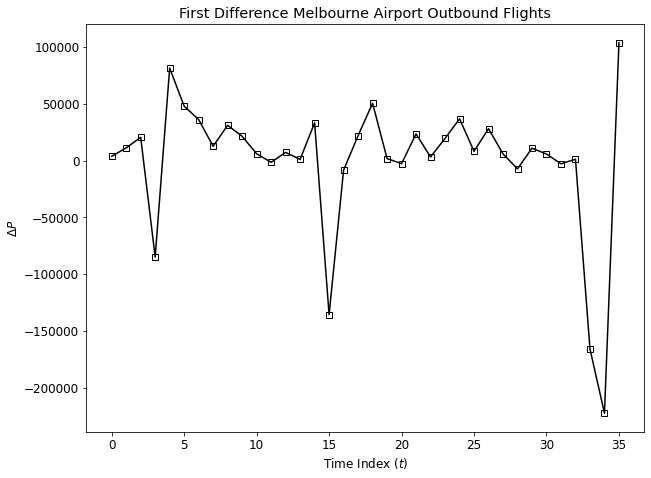

In [217]:
X_diff = X[1:] - X[0:-1]
plt.plot( X_diff,  "k", marker='s', markerfacecolor='none')
plt.title('First Difference Melbourne Airport Outbound Flights')
plt.ylabel("$\Delta P$")
plt.xlabel("Time Index $(t)$")
#save figure
# plt.savefig(figurepath+"/MA2.pdf", format="pdf", bbox_inches="tight")
plt.show()

The series is now stationary.

In [218]:
#ADF test
result = adfuller(X_diff)
print(result)

(-4.431019934859029, 0.00026147717348707294, 1, 34, {'1%': -3.639224104416853, '5%': -2.9512301791166293, '10%': -2.614446989619377}, 629.3099338490788)


## Moving Average Series (MA)

#### We can simulate MA series by sepcifing MA and AR polynomial coefficients.

In [8]:
plt.rcParams.update({'font.size': 18})

ar1 = np.array([1,0])
ma1 = np.array([1, 0, 2])
ARMA_1 = ArmaProcess(ar1,ma1).generate_sample(nsample=200)

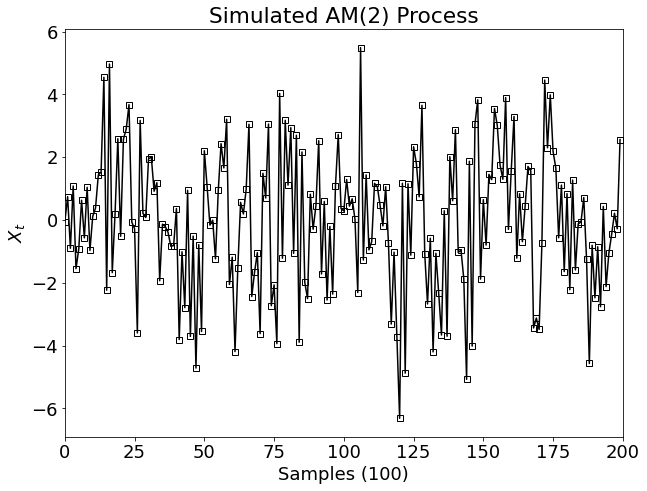

In [9]:
plt.plot( ARMA_1,  "k", marker='s', markerfacecolor='none')
plt.title('Simulated AM(2) Process')
plt.xlim([0,200])
plt.ylabel("$X_t$")
plt.xlabel("Samples (100)")
#save figure
plt.savefig(figurepath+"/MA2.pdf", format="pdf", bbox_inches="tight")
plt.show()

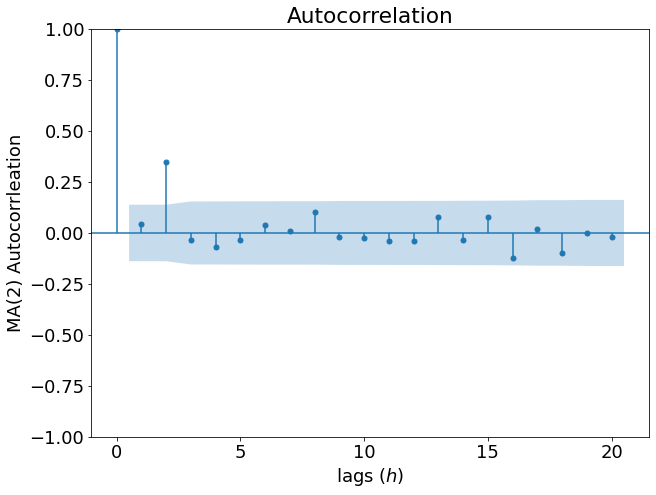

In [10]:
#plot ACVF
plot_acf(ARMA_1, lags =20)
plt.xlabel("lags $(h)$")
plt.ylabel("MA(2) Autocorrleation")
plt.savefig(figurepath+"/MA2corr.pdf", format="pdf", bbox_inches="tight")
plt.show()

#### We can alo grab the information and plot it in style we prefer.

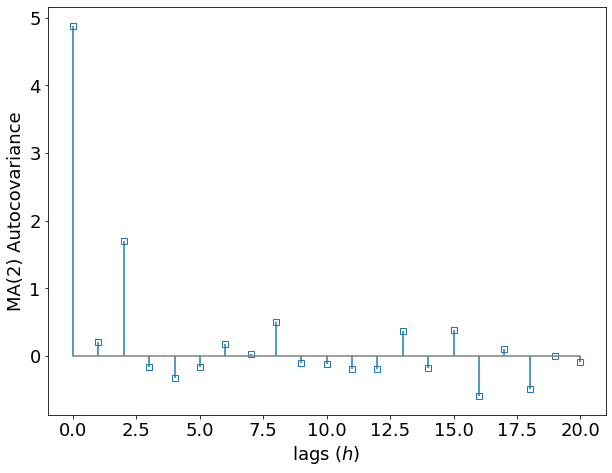

In [11]:
simulated_acv = statsmodels.tsa.stattools.acovf(ARMA_1,nlag =20)
markerline, stemlines, baseline = plt.stem(range(len(simulated_acv)),simulated_acv, markerfmt="s", basefmt="C7")
markerline.set_markerfacecolor('None')
plt.xlabel("lags $(h)$")
plt.ylabel("MA(2) Autocovariance")
plt.savefig(figurepath+"/MA2covCustom.pdf", format="pdf", bbox_inches="tight")
plt.show()

#### Statsmodels can also calculate theoretical ACVF

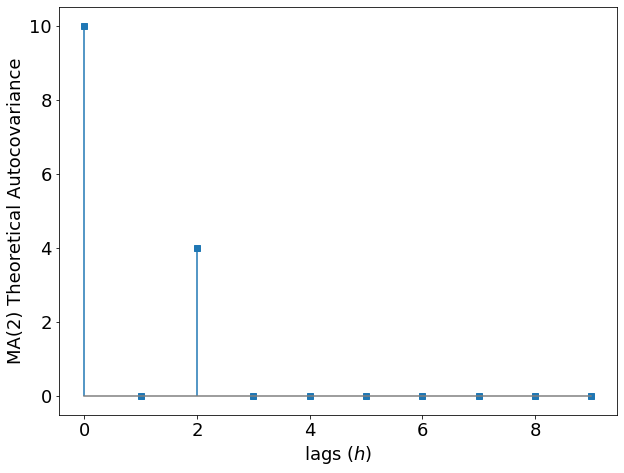

In [12]:
acvf = statsmodels.tsa.arima_process.arma_acovf(ar1, ma1, nobs=10, sigma2=2, dtype=None)
plt.stem(range(len(acvf)),acvf, markerfmt='s',  basefmt="C7")
plt.xlabel("lags $(h)$")
plt.ylabel("MA(2) Theoretical Autocovariance")
plt.savefig(figurepath+"/MA2theoreticalACVF.pdf", format="pdf", bbox_inches="tight")
plt.show()

### MA Fit of Lake Huron Data

First lets calculate the autocorrelation of the residuals.

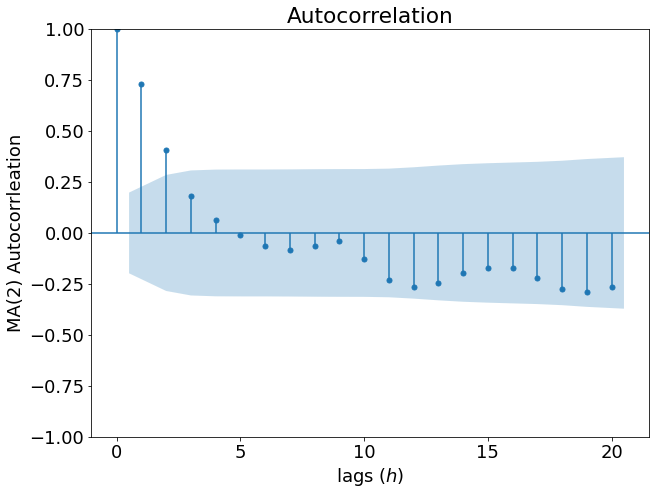

In [13]:
plot_acf(resds, lags =20)
plt.xlabel("lags $(h)$")
plt.ylabel("MA(2) Autocorrleation")
plt.show()

In [59]:
#Checking if the data is stationary
result = adfuller(data)
# Print test statistic
print(result)


(-3.8976683843687763, 0.0020520736790759007, 1, 96, {'1%': -3.5003788874873405, '5%': -2.8921519665075235, '10%': -2.5830997960069446}, 179.33694888946826)


### Forecsting out of sample data.

In [133]:
model = ARIMA(data[0:-1], order=(0,0,2)) 
results = model.fit()

# Make predictions for the test set
forecast = results.predict(start=0, end=97)
## get MSE
MSE_MA =((data - forecast)**2).mean()

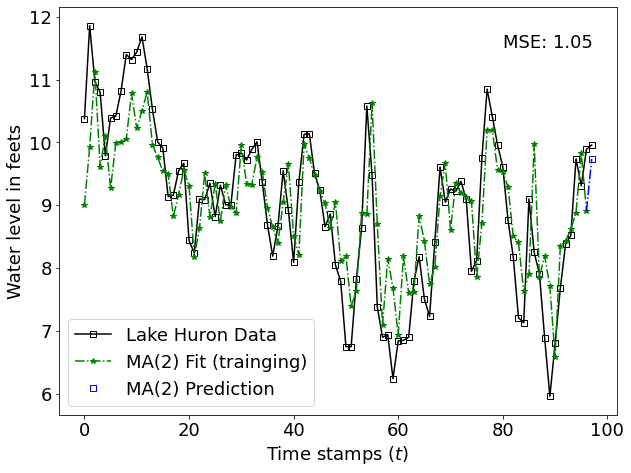

In [176]:
predtimes = np.arange(0,len(forecast))
plt.figure()
plt.plot(dataTime, data,  "k", marker='s', markerfacecolor='none')
plt.plot(predtimes[0:-1], forecast[0:-1], 'g*-.')
plt.plot(predtimes[-1:], forecast[-1:], 'bs',  markerfacecolor='none')
plt.plot(predtimes[-2:], forecast[-2:], 'b-.') 
plt.xlabel("Time stamps $(t)$")
plt.ylabel("Water level in feets")
plt.legend(["Lake Huron Data", "MA(2) Fit (trainging)", "MA(2) Prediction"])
plt.text(80, 11.5, "MSE: {:.2f}".format(MSE_MA))

#save figure
plt.show()

### Fitting an AR model

In [154]:
# Model summary
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   97
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -110.791
Date:                Tue, 04 Jul 2023   AIC                            229.581
Time:                        17:38:38   BIC                            239.880
Sample:                             0   HQIC                           233.745
                                 - 97                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.0077      0.197     45.702      0.000       8.621       9.394
ma.L1          1.0136      0.090     11.252      0.000       0.837       1.190
ma.L2          0.5007      0.102      4.900      0.000       0.300       0.701
sigma2         0.5679      0.090      6.320      0.000       0.392       0.744
===================================================================================
Ljung-Box (L1) (Q):                   2.41   Jarque-Bera (JB):                 0.59
Prob(Q):                              0.12   Prob(JB):                         0.75
Heteroskedasticity (H):               1.16   Skew:                            -0.13
Prob(H) (two-sided):                  0.68   Kurtosis:                         2.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

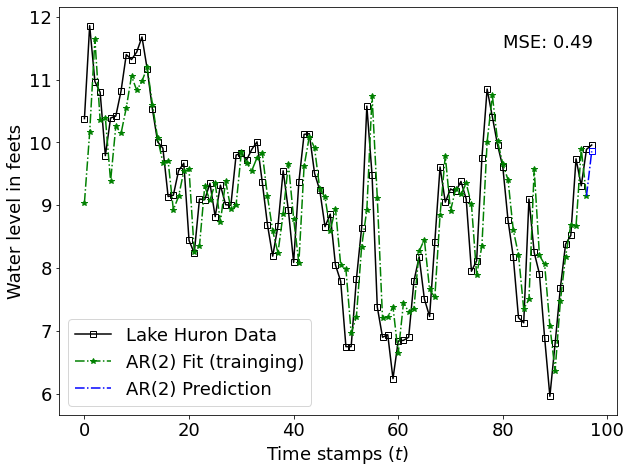

In [175]:
modelAR = ARIMA(data[0:-1], order=(2,0,0)) 
resultsAR = modelAR.fit()
# Make predictions for the test set
forecastAR = resultsAR.predict(start=0, end=97)
MSE_AR =((data - forecastAR)**2).mean()

predtimes = np.arange(0,len(forecastAR))
plt.figure()
plt.plot(dataTime, data,  "k", marker='s', markerfacecolor='none')
plt.plot(predtimes[0:-1], forecastAR[0:-1], 'g*-.')
#connect the plots
plt.plot(predtimes[-2:], forecastAR[-2:], 'b-.') 
plt.plot(predtimes[-1:], forecastAR[-1:], 'bs',  markerfacecolor='none')
plt.xlabel("Time stamps $(t)$")
plt.ylabel("Water level in feets")
plt.legend(["Lake Huron Data", "AR(2) Fit (trainging)", "AR(2) Prediction"])
plt.text(80, 11.5, "MSE: {:.2f}".format(MSE_AR))

#save figure
plt.show()


In [125]:
# Model summary
resultsAR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   97
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -103.070
Date:                Tue, 04 Jul 2023   AIC                            214.139
Time:                        17:16:51   BIC                            224.438
Sample:                             0   HQIC                           218.304
                                 - 97                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.0426      0.348     26.004      0.000       8.361       9.724
ar.L1          1.0423      0.092     11.299      0.000       0.861       1.223
ar.L2         -0.2486      0.091     -2.722      0.006      -0.428      -0.070
sigma2         0.4837      0.073      6.609      0.000       0.340       0.627
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 0.22
Prob(Q):                              0.77   Prob(JB):                         0.90
Heteroskedasticity (H):               1.60   Skew:                             0.09
Prob(H) (two-sided):                  0.19   Kurtosis:                         2.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""